In [20]:
import numpy as np 
import pandas as pd 
import os
import pickle
import torch
from IPython.display import clear_output
import json
from sklearn.metrics import f1_score
import cv2
from torchvision import transforms as T
from PIL import Image
from matplotlib import pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, tqdm_notebook
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn

In [21]:
def make_df(mode):
    if mode == 'train':
        mode = 'Training'
    elif mode =='val':
        mode = 'Validation'
    elif mode == 'test':
        mode = 'Test'
    else:
        print('Неверно введен mode')
        return
    df_res = pd.DataFrame(columns = ['files', 'class'])
    list_of_cls = os.listdir('../input/fruits/fruits-360_dataset/fruits-360/'+ mode)
    for item in list_of_cls:
        lst = [item] * len(os.listdir('../input/fruits/fruits-360_dataset/fruits-360/'+mode+'/'+item))
        file = os.listdir('../input/fruits/fruits-360_dataset/fruits-360/'+mode+'/'+item)
        data = {'files': file,
                'names': [lst[i]+str(i) for i in range(len(file))],
                'class': lst}
        df = pd.DataFrame(data)   
        df_res = df_res.append(df,ignore_index = True)
    return df_res

In [22]:
tr_df = make_df('train')
tst_df = make_df('test')

In [23]:
tr_df.head()

,files,class,names
0,r_305_100.jpg,Quince,Quince0
1,139_100.jpg,Quince,Quince1
2,128_100.jpg,Quince,Quince2
3,r_239_100.jpg,Quince,Quince3
4,185_100.jpg,Quince,Quince4


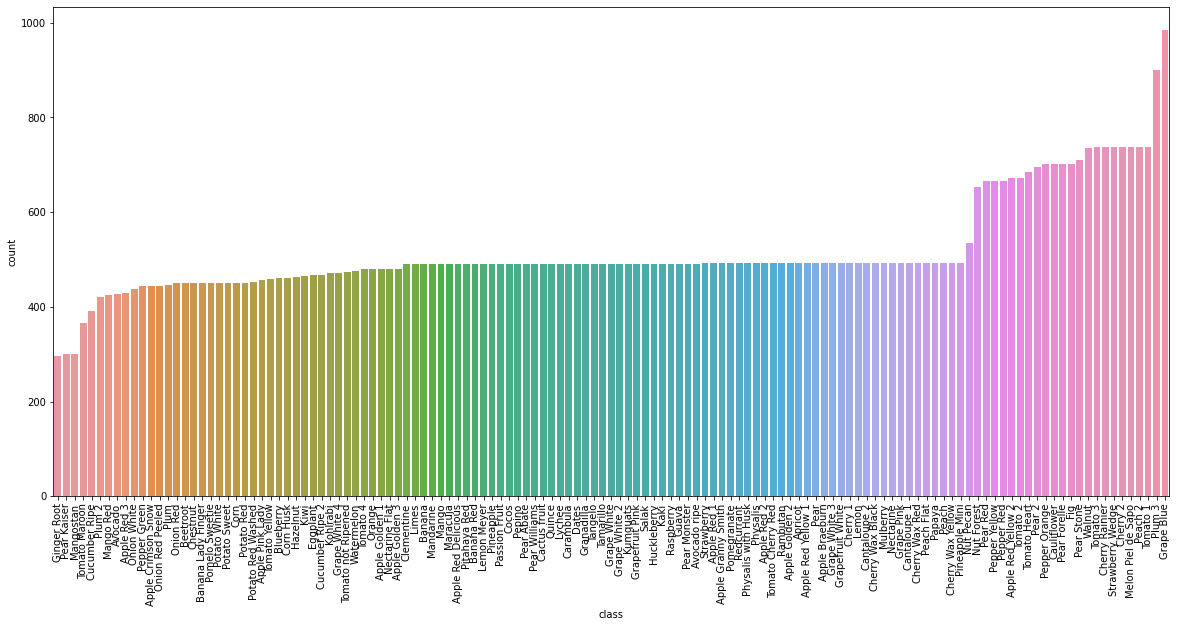

In [24]:
import seaborn as sns
df =pd.DataFrame(tr_df['class'])

df['count'] = 1
data = df.groupby('class').count().sort_values('count')
data.head()
plt.figure(figsize=(20, 9))
sns.barplot(x=data.index, y=data.iloc[:,0], orient='v').set_xticklabels(data.index, rotation=90)
    
plt.show()

In [25]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DATA_MODES = ['train', 'val', 'test']
DEVICE = torch.device("cuda")
RESCALE_SIZE_1 =100
RESCALE_SIZE_2 =100

CUDA is available!  Training on GPU ...


In [26]:
le = LabelEncoder()
tr_df['class_enc'] = le.fit_transform(tr_df['class'].values.ravel())
le.classes_
with open('label_encoder.pkl', 'wb') as le_dump_file:
     pickle.dump(le, le_dump_file)

In [27]:
class FruitsDataset(Dataset):
    def __init__(self, names, df, mode):
        super().__init__()
        self.names = names
        self.mode = mode
        self.df = df
        self.len_ = len(self.names)

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
    def __len__(self):
        return self.len_
      
    def load_sample(self, file,cl, mode):
        if mode == 'test':
            image = Image.open('../input/fruits/fruits-360_dataset/fruits-360/Test/'+cl+'/'+ file).convert("RGB")
        else:
            image = Image.open('../input/fruits/fruits-360_dataset/fruits-360/Training/'+cl+'/'+ file).convert("RGB")
        image.load()
        return image
    
    def __getitem__(self, index):
            transforms = T.Compose([T.ToTensor(),
                         T.RandomHorizontalFlip(),
                         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
            transforms_train = T.Compose([T.ToTensor(),
                         T.RandomHorizontalFlip(),
                         T.RandomRotation(10),
                         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
            clss = self.df['class'].loc[self.df['names'] == self.names[index]].item()
            name = self.df['files'].loc[self.df['names'] == self.names[index]].item()
            x = self.load_sample(name,clss,self.mode)
#             x = self._prepare_sample(x)
            x = np.array(x, dtype='float32')/ 255
            if self.mode == 'test':
                x = transforms(x)
                return x, self.df['class'].loc[self.df['names'] == self.names[index]].item()
            else:
                x = transforms_train(x)
                y = self.df['class_enc'].loc[self.df['names'] == self.names[index]].item()
                return x, y
            
            
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE_1, RESCALE_SIZE_2))
        return image

In [28]:
train_files,val_files = train_test_split(tr_df['names'], train_size=0.75)
val_dataset = FruitsDataset(list(val_files), tr_df,  mode='val')
train_dataset = FruitsDataset(list(train_files),tr_df, mode='train')

In [29]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

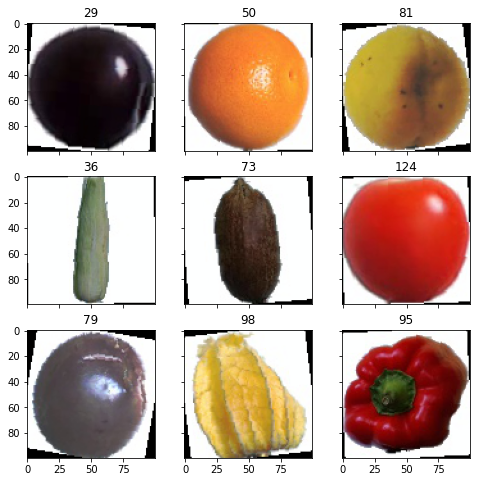

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_class = int(np.random.uniform(0,15501))
    im_val, label = val_dataset[random_class]
    img_label = str(val_dataset[random_class][1])
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [31]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    train_f1_score = []
    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        train_f1_score.append(f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro'))
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = np.average(train_f1_score)
    
    return train_loss, train_acc, train_f1

In [32]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    val_f1_score = []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        val_f1_score.append(f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro'))
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_f1 = np.average(val_f1_score)
    return val_loss, val_acc,val_f1

In [33]:
def train(train_files, val_files, model, epochs, batch_size, lrate=0.001, model_name ='model'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers = 2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers = 2, shuffle=False)
    max_val = 0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=lrate)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc,train_f1 = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss, val_acc,val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if max_val<val_f1:
                max_val = val_f1
                torch.save(model, './'+model_name+'.dat')
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, t_f1 = train_f1, v_f1 =val_f1))
            
    return history

In [34]:
n_classes = tr_df['class'].nunique()

In [35]:
ResNet18 = models.resnet18(pretrained=False)
ResNet18.fc = nn.Linear(512, n_classes)
ResNet18.to(DEVICE)
print("we will classify :{}".format(n_classes))
# print(ResNet18)

we will classify :131


In [36]:
history_1 = train(train_dataset, val_dataset, model=ResNet18, epochs=7, batch_size=32, model_name = 'resnet18')

epoch:  14%|█▍        | 1/7 [17:09<1:42:54, 1029.07s/it]


Epoch 001 train_loss: 0.7755     val_loss 0.2592 train_acc 0.7693 val_acc 0.9134 train_f1 0.6731 val_f1 0.8509


epoch:  29%|██▊       | 2/7 [32:44<1:21:10, 974.16s/it] 


Epoch 002 train_loss: 0.2548     val_loss 0.0302 train_acc 0.9278 val_acc 0.9899 train_f1 0.8858 val_f1 0.9814


epoch:  43%|████▎     | 3/7 [48:20<1:03:46, 956.65s/it]


Epoch 003 train_loss: 0.0728     val_loss 0.0132 train_acc 0.9779 val_acc 0.9969 train_f1 0.9604 val_f1 0.9943


epoch:  57%|█████▋    | 4/7 [1:03:43<47:09, 943.25s/it]


Epoch 004 train_loss: 0.0461     val_loss 0.0857 train_acc 0.9868 val_acc 0.9910 train_f1 0.9762 val_f1 0.9839


epoch:  71%|███████▏  | 5/7 [1:19:08<31:13, 936.90s/it]


Epoch 005 train_loss: 0.0473     val_loss 0.0228 train_acc 0.9874 val_acc 0.9947 train_f1 0.9772 val_f1 0.9903


epoch:  86%|████████▌ | 6/7 [1:34:34<15:33, 933.16s/it]


Epoch 006 train_loss: 0.0349     val_loss 0.0402 train_acc 0.9897 val_acc 0.9894 train_f1 0.9811 val_f1 0.9811


epoch: 100%|██████████| 7/7 [1:49:59<00:00, 942.81s/it]


Epoch 007 train_loss: 0.0239     val_loss 0.0558 train_acc 0.9930 val_acc 0.9822 train_f1 0.9876 val_f1 0.9669


In [37]:
loss, acc, val_loss, val_acc = zip(*history_1)

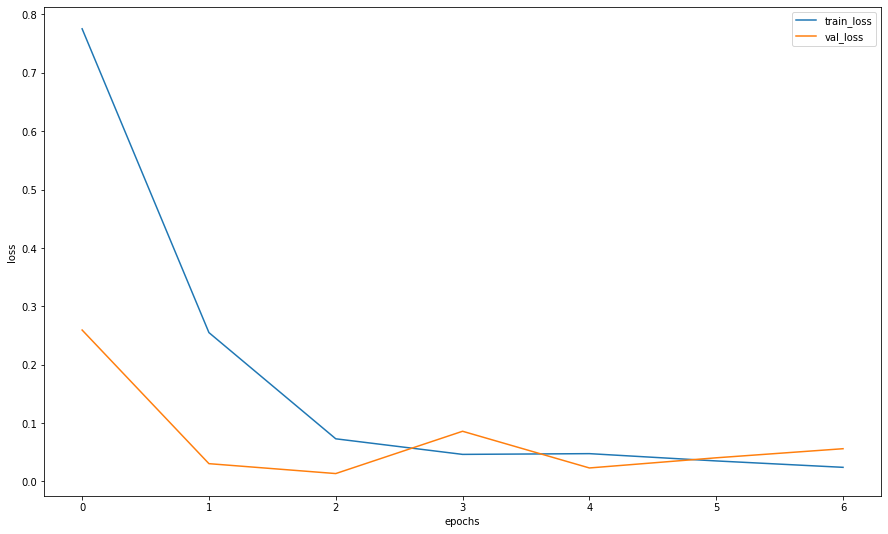

In [40]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [41]:
densenet121 = models.densenet121(pretrained = False)
densenet121.fc = nn.Linear(1024, n_classes)
densenet121.to(DEVICE)
print("we will classify :{}".format(n_classes))
# print(densenet121)

we will classify :131


In [42]:
history_2 = train(train_dataset, val_dataset, model=densenet121, epochs=6, batch_size=50, model_name = 'densenet121')

epoch:  17%|█▋        | 1/6 [16:06<1:20:33, 966.66s/it]


Epoch 001 train_loss: 0.5442     val_loss 0.1360 train_acc 0.8528 val_acc 0.9521 train_f1 0.7830 val_f1 0.9156


epoch:  33%|███▎      | 2/6 [32:00<1:03:56, 959.10s/it]


Epoch 002 train_loss: 0.1565     val_loss 0.0437 train_acc 0.9535 val_acc 0.9833 train_f1 0.9254 val_f1 0.9699


epoch:  50%|█████     | 3/6 [47:52<47:47, 955.80s/it]  


Epoch 003 train_loss: 0.0516     val_loss 0.0301 train_acc 0.9852 val_acc 0.9885 train_f1 0.9738 val_f1 0.9798


epoch:  67%|██████▋   | 4/6 [1:03:47<31:51, 955.52s/it]


Epoch 004 train_loss: 0.0304     val_loss 0.0394 train_acc 0.9914 val_acc 0.9892 train_f1 0.9842 val_f1 0.9809


epoch:  83%|████████▎ | 5/6 [1:19:43<15:55, 955.56s/it]


Epoch 005 train_loss: 0.0369     val_loss 0.0048 train_acc 0.9900 val_acc 0.9989 train_f1 0.9821 val_f1 0.9981


epoch: 100%|██████████| 6/6 [1:35:38<00:00, 956.42s/it]


Epoch 006 train_loss: 0.0260     val_loss 0.0008 train_acc 0.9928 val_acc 0.9999 train_f1 0.9870 val_f1 0.9999


In [43]:
loss, acc, val_loss, val_acc = zip(*history_2)

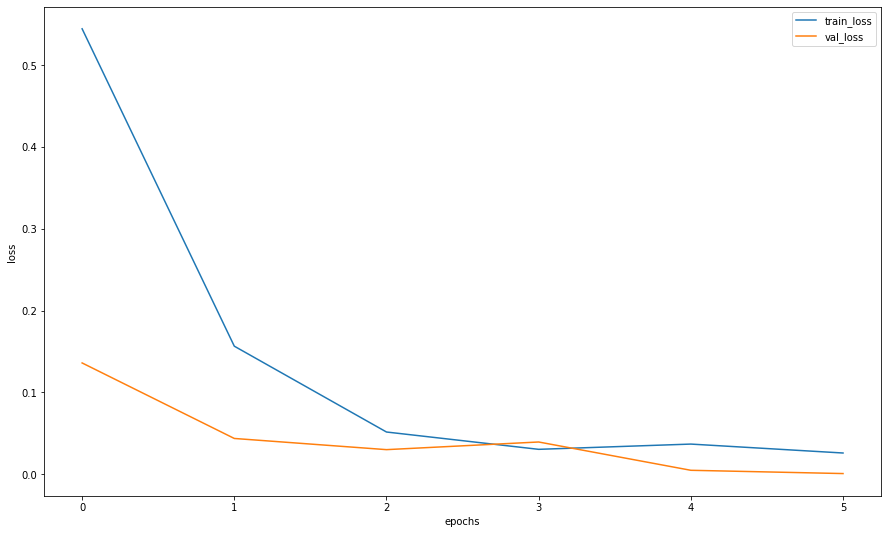

In [44]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [45]:
vgg16 = models.vgg16(pretrained = False)
vgg16.fc = nn.Linear(4096, n_classes)
vgg16.to(DEVICE)
print("we will classify :{}".format(n_classes))
# print(vgg16)

we will classify :131


In [46]:
history_3 = train(train_dataset, val_dataset, model=vgg16, epochs=7, batch_size=50,lrate = 0.0001, model_name='vgg16')

epoch:  14%|█▍        | 1/7 [15:42<1:34:13, 942.20s/it]


Epoch 001 train_loss: 2.1125     val_loss 0.2646 train_acc 0.4568 val_acc 0.9113 train_f1 0.3608 val_f1 0.8488


epoch:  29%|██▊       | 2/7 [31:35<1:19:04, 948.93s/it]


Epoch 002 train_loss: 0.1832     val_loss 0.0819 train_acc 0.9409 val_acc 0.9779 train_f1 0.8982 val_f1 0.9601


epoch:  43%|████▎     | 3/7 [47:29<1:03:23, 950.93s/it]


Epoch 003 train_loss: 0.0915     val_loss 0.0351 train_acc 0.9715 val_acc 0.9883 train_f1 0.9498 val_f1 0.9792


epoch:  57%|█████▋    | 4/7 [1:03:22<47:35, 951.81s/it]


Epoch 004 train_loss: 0.0804     val_loss 0.0542 train_acc 0.9769 val_acc 0.9856 train_f1 0.9589 val_f1 0.9732


epoch:  71%|███████▏  | 5/7 [1:19:25<31:51, 955.81s/it]


Epoch 005 train_loss: 0.0555     val_loss 0.0137 train_acc 0.9836 val_acc 0.9960 train_f1 0.9707 val_f1 0.9925


epoch:  86%|████████▌ | 6/7 [1:35:22<15:56, 956.34s/it]


Epoch 006 train_loss: 0.0556     val_loss 0.0842 train_acc 0.9841 val_acc 0.9771 train_f1 0.9721 val_f1 0.9596


epoch: 100%|██████████| 7/7 [1:51:17<00:00, 953.97s/it]


Epoch 007 train_loss: 0.0463     val_loss 0.0306 train_acc 0.9873 val_acc 0.9910 train_f1 0.9770 val_f1 0.9830


In [47]:
loss, acc, val_loss, val_acc = zip(*history_3)

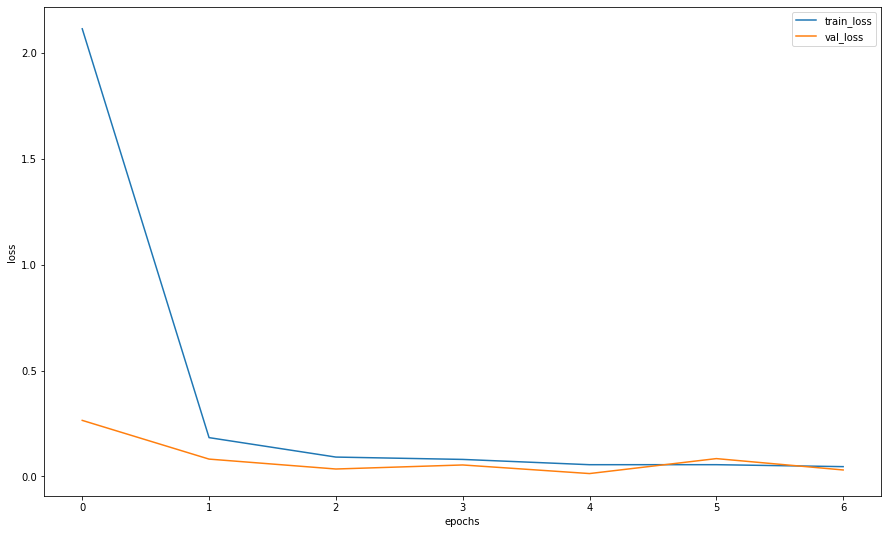

In [48]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [49]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [65]:
def make_f1_score(model):
    test_dataset = FruitsDataset(tst_df['names'].values, tst_df, mode = 'test')
    idxs = list(map(int, np.random.uniform(0,len(test_dataset), len(test_dataset))))
    imgs = [test_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(ResNet18, imgs)
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [test_dataset[i][1] for i in idxs]
    preds_class = [le.classes_[item] for item in y_pred]
    return f1_score(actual_labels, preds_class, average='macro')

In [58]:
vgg16 = torch.load('./vgg16.dat')
make_f1_score(vgg16) #0.971252752097586

0.9600516736389677

In [66]:
densenet121 = torch.load('./densenet121.dat')
make_f1_score(densenet121)#0.9733644876352412

0.9603215448547727

In [67]:
ResNet18 = torch.load('./resnet18.dat')
make_f1_score(ResNet18)#0.97764

0.9618900474706022

In [54]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

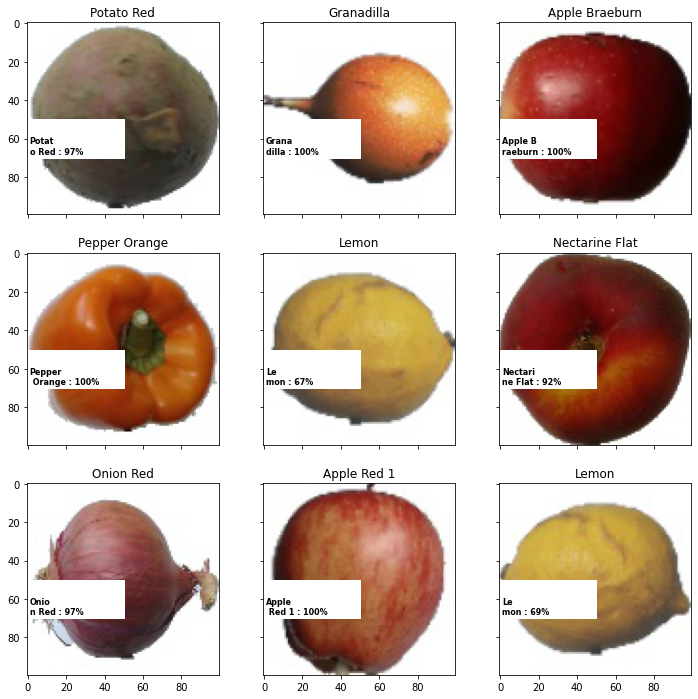

In [68]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
test_dataset = FruitsDataset(tst_df['names'].values, tst_df, mode = 'test')
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,20000))
    im_val, label = test_dataset[random_characters]
    
    

    imshow(im_val.data.cpu(), \
          title=label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(label)
            
    fig_x.add_patch(patches.Rectangle((0,50),50,20,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    #prob_pred = predict_one_sample(vgg16, im_val.unsqueeze(0))
    #prob_pred = predict_one_sample(densenet121, im_val.unsqueeze(0))
    prob_pred = predict_one_sample(ResNet18, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = le.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')